In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [9]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')

if src_path not in sys.path:
    sys.path.append(src_path)

In [10]:
from utils import load_data, transform_data
from data_vis import plot_candlestick, plot_time_series, plot_normalized_pair, plot_series
from comp_utils import find_best_pair_for_ticker, get_pairs, get_residuals

In [11]:
btc_data = transform_data(load_data("BTCUSDT"))
eth_data = transform_data(load_data("ETHUSDT"))
ada_data = transform_data(load_data("ADAUSDT"))
bnb_data = transform_data(load_data("BNBUSDT"))
doge_data = transform_data(load_data("DOGEUSDT"))
link_data = transform_data(load_data("LINKUSDT"))
sol_data = transform_data(load_data("SOLUSDT"))
wbtc_data = transform_data(load_data("WBTC"))
xrp_data = transform_data(load_data("XRPUSDT"))
usdc_data = transform_data(load_data("USDCUSDT"))
avax_data = transform_data(load_data("AVAXUSDT"))
bch_data = transform_data(load_data("BCHUSDT"))
dai_data = transform_data(load_data("DAIUSDT"))
ltc_data = transform_data(load_data("LTCUSDT"))
xlm_data = transform_data(load_data("XLMUSDT"))

In [12]:
#Candlestick charts for visualization
plot_candlestick(btc_data, "BTCUSDT", start_idx=0, end_idx=200)

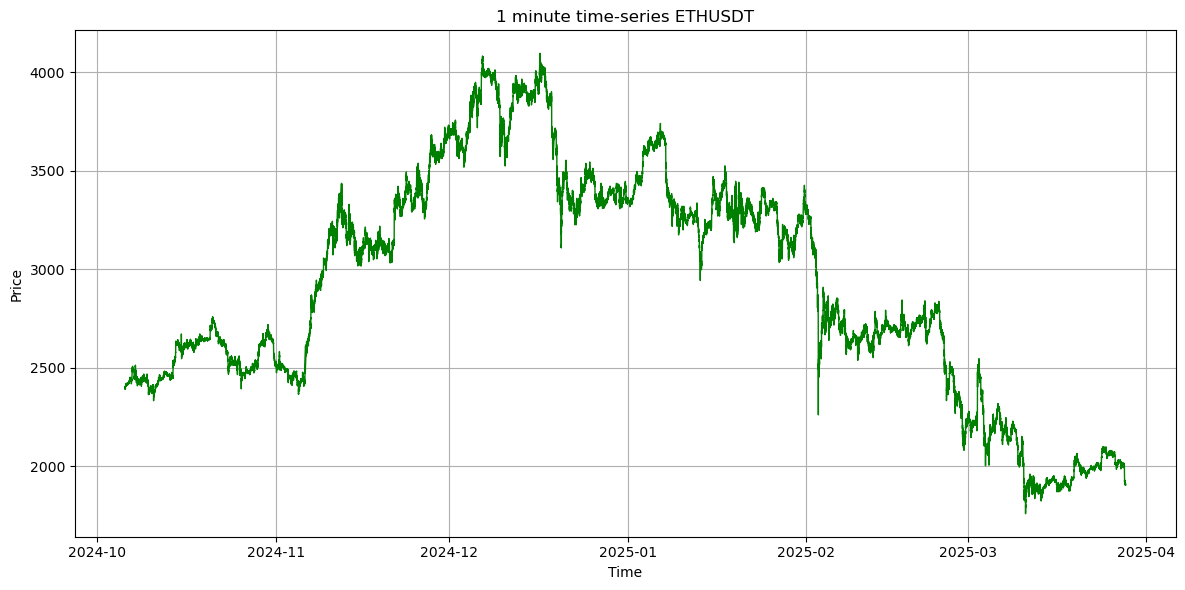

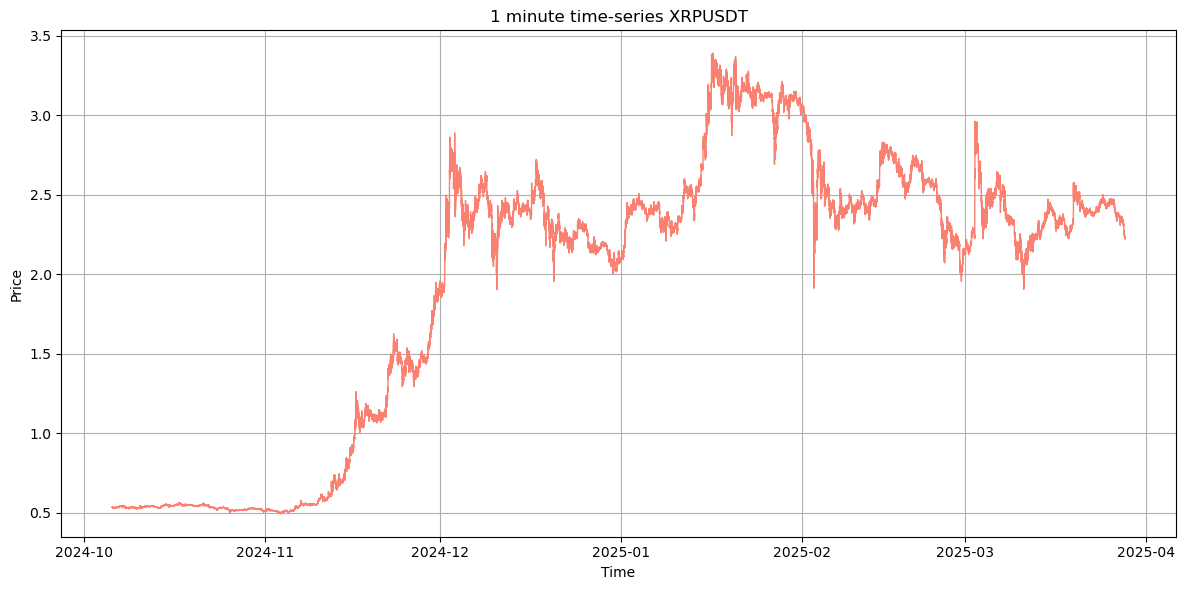

In [13]:
#visualize the mid-price time-series 
plot_time_series(eth_data, ticker="ETHUSDT", color='green', start_idx=400000, end_idx=650000)
plot_time_series(xrp_data, ticker="XRPUSDT", color='salmon', start_idx=400000, end_idx=650000)

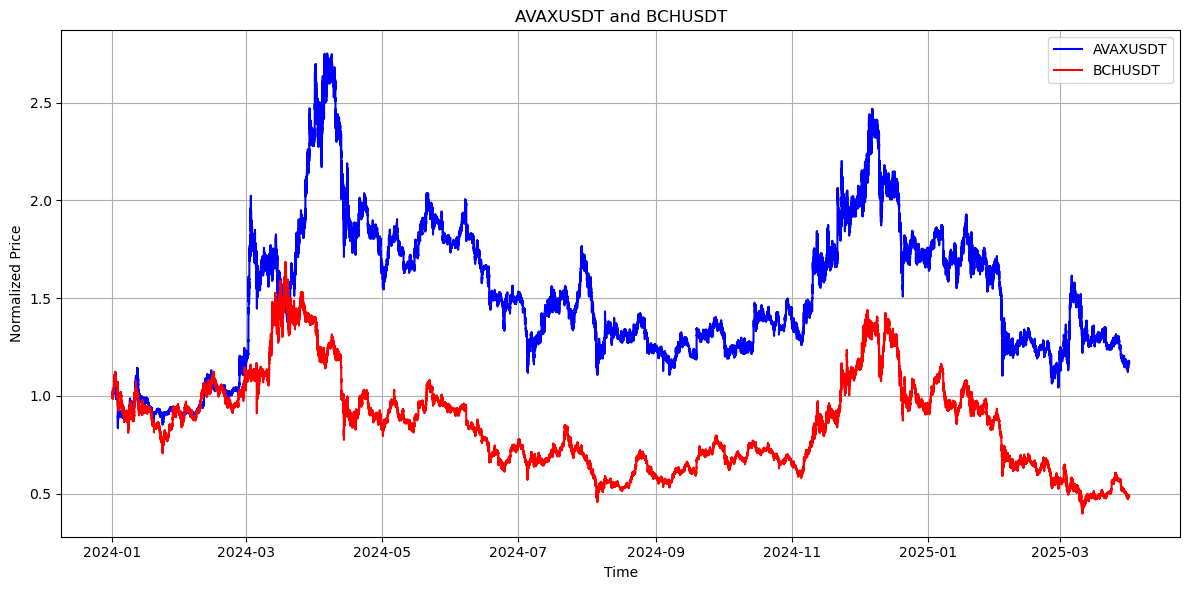

In [14]:
# visualize the normalized time-series of two assets on a normalized y-axis 
plot_normalized_pair(bch_data, avax_data, title="AVAXUSDT and BCHUSDT", label1="AVAXUSDT", label2="BCHUSDT", color2 = 'red')

In [213]:
data_dict = {
    "BTCUSDT": btc_data, 
    "ETHUSDT": eth_data, 
    "ADAUSDT": ada_data, 
    "BNBUSDT": bnb_data, 
    #"DOGEUSDT": doge_data, 
    #"LINKUSDT": link_data,
    "SOLUSDT": sol_data, 
    #"WBTC": wbtc_data, 
    #"XRPUSDT": xrp_data, 
    "BCHUSDT": bch_data,
    #"DAIUSDT": dai_data,
    #"LTCUSDT": ltc_data,
    "XLMUSDT": xlm_data,
    "AVAXUSDT": avax_data,
}

## PCA Stat Arb Implementation
#### 1. Computing PCA factors

In [214]:
from comp_utils import get_Y, fit_ou_params

In [215]:
# our N x M standardized returns matrix 
Y = get_Y(data_dict)
Y

array([[-1.29616895, -1.67408114, -0.05558414, ...,  0.02176366,
         0.01948536,  0.0194953 ],
       [ 1.97244513, -0.30646456, -0.1723905 , ...,  2.16723645,
        -0.54446303, -0.00525117],
       [-0.05764572, -1.17301734, -0.03482777, ...,  0.23661429,
         0.20914344,  0.20914344],
       ...,
       [ 0.01546125,  0.01546125,  0.01546125, ..., -0.04398679,
        -0.04959629, -0.05877126],
       [ 0.04054583,  0.04054583,  0.04054583, ...,  0.18296666,
        -2.31390035,  0.07452145],
       [-0.21467814, -0.21273149, -0.07368981, ...,  0.03114243,
         0.03114243,  0.03114243]])

In [216]:
# constructing the N x N correlation matrix 
M = Y.shape[1]
P = (1 / (M - 1)) * (Y @ Y.T)
P

array([[1.00719032, 0.28262102, 0.19437295, 0.14130698, 0.18722342,
        0.06748182, 0.10421717, 0.18417658],
       [0.28262102, 1.01392843, 0.21967865, 0.15367514, 0.19502081,
        0.07802384, 0.12356705, 0.20901674],
       [0.19437295, 0.21967865, 0.99806435, 0.12652617, 0.14577689,
        0.07337618, 0.13654392, 0.19728612],
       [0.14130698, 0.15367514, 0.12652617, 1.00537521, 0.10454713,
        0.05384433, 0.07200029, 0.11976445],
       [0.18722342, 0.19502081, 0.14577689, 0.10454713, 1.00016435,
        0.05455423, 0.06467732, 0.1448665 ],
       [0.06748182, 0.07802384, 0.07337618, 0.05384433, 0.05455423,
        1.04431464, 0.05476671, 0.07518933],
       [0.10421717, 0.12356705, 0.13654392, 0.07200029, 0.06467732,
        0.05476671, 1.02207605, 0.12055064],
       [0.18417658, 0.20901674, 0.19728612, 0.11976445, 0.1448665 ,
        0.07518933, 0.12055064, 0.99560912]])

In [217]:
# computing the principal components 
eigenvalues, eigenvectors = np.linalg.eigh(P)
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

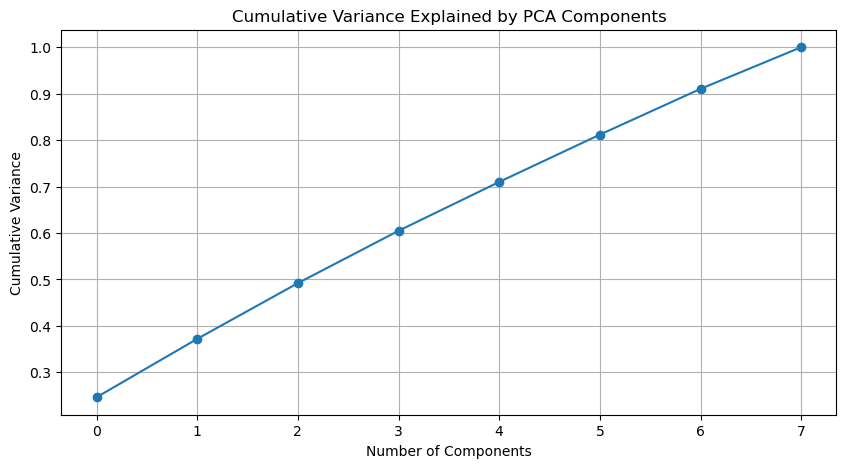

In [218]:
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o')
plt.title("Cumulative Variance Explained by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.show()


#### 2. Constructing Eigenportfolios

In [219]:
k = 7 # number of eigenportfolios, explains roughly 0.1k variance

In [220]:
# constructing the Q_matrix, each column is an eigenportfolio
volatilities = np.std(Y, axis=1)
top_k_eigenvectors = eigenvectors[:, :k]
Q_matrix = top_k_eigenvectors / volatilities[:, np.newaxis]

In [221]:
asset_names = list(data_dict.keys())
print("="*60)
print("Q_matrix shape:", Q_matrix.shape)
print("Eigenportfolio 3 weights:")
for name, weight in zip(asset_names, Q_matrix[:, 2]):
    print(f"{name}: {weight:.4f}")

Q_matrix shape: (8, 7)
Eigenportfolio 3 weights:
BTCUSDT: -0.1560
ETHUSDT: -0.0968
ADAUSDT: 0.1470
BNBUSDT: -0.1582
SOLUSDT: -0.3190
BCHUSDT: -0.2641
XLMUSDT: 0.8494
AVAXUSDT: 0.0853


In [222]:
# each row of F matrix is a factor return time-series; there are k rows
F_matrix = Q_matrix.T @ Y

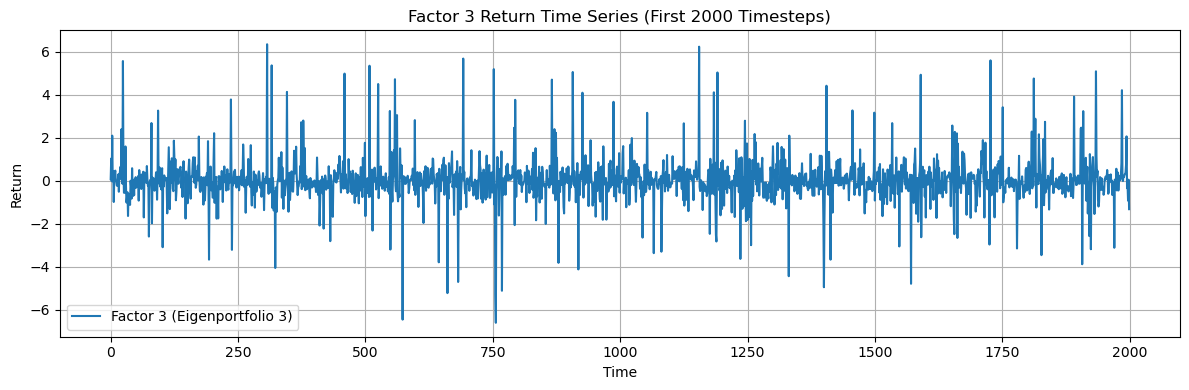

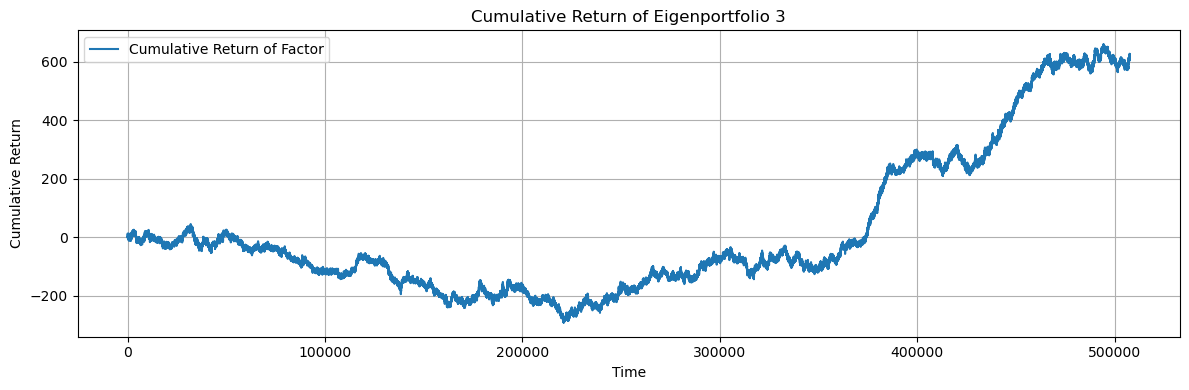

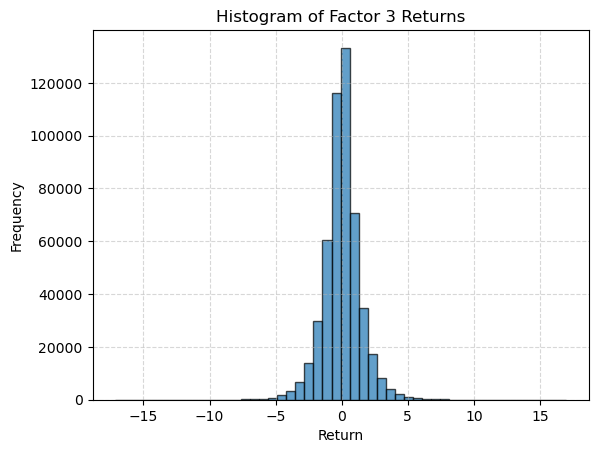

In [223]:
# visualizing factor returns 

plt.figure(figsize=(12, 4))
plt.plot(F_matrix[2][:2000], label='Factor 3 (Eigenportfolio 3)')
plt.title("Factor 3 Return Time Series (First 2000 Timesteps)")
plt.xlabel("Time")
plt.ylabel("Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

cumulative_factor = np.cumsum(F_matrix[2])

plt.figure(figsize=(12, 4))
plt.plot(cumulative_factor, label='Cumulative Return of Factor')
plt.title("Cumulative Return of Eigenportfolio 3")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.hist(F_matrix[0], bins=50, edgecolor='black', alpha=0.7)
plt.title("Histogram of Factor 3 Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [224]:
# solve linear-regression least squares to regress returns 
FF_inv = np.linalg.inv(F_matrix @ F_matrix.T)
beta_matrix = (Y @ F_matrix.T) @ FF_inv
Y_hat = beta_matrix @ F_matrix
residuals = Y - Y_hat

In [225]:
X_matrix = np.cumsum(residuals, axis=1)

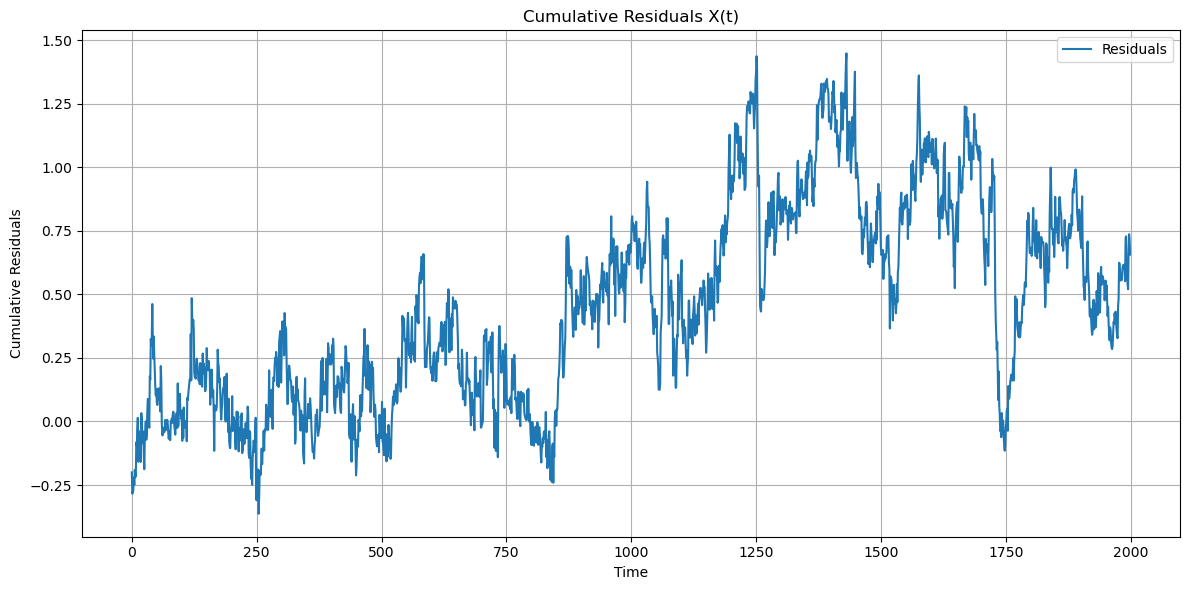

In [226]:
plt.figure(figsize=(12, 6))
plt.plot(X_matrix[2][:2000], label='Residuals')
plt.title("Cumulative Residuals X(t)")
plt.xlabel("Time")
plt.ylabel("Cumulative Residuals")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [227]:
s_scores = np.zeros_like(X_matrix)

ou_params = []

for i in range(X_matrix.shape[0]):
    X_series = X_matrix[i]
    a, b, kappa, m, sigma, sigma_eq = fit_ou_params(X_series)
    s_scores[i] = (X_series - m) / sigma_eq
    ou_params.append((a, b, kappa, m, sigma, sigma_eq))

In [228]:
from backtester import generate_signals

In [229]:
# N x M positions matrix encoding our position by asset at time t 
positions = generate_signals(s_scores, s_entry=1.25, s_exit=0.5)

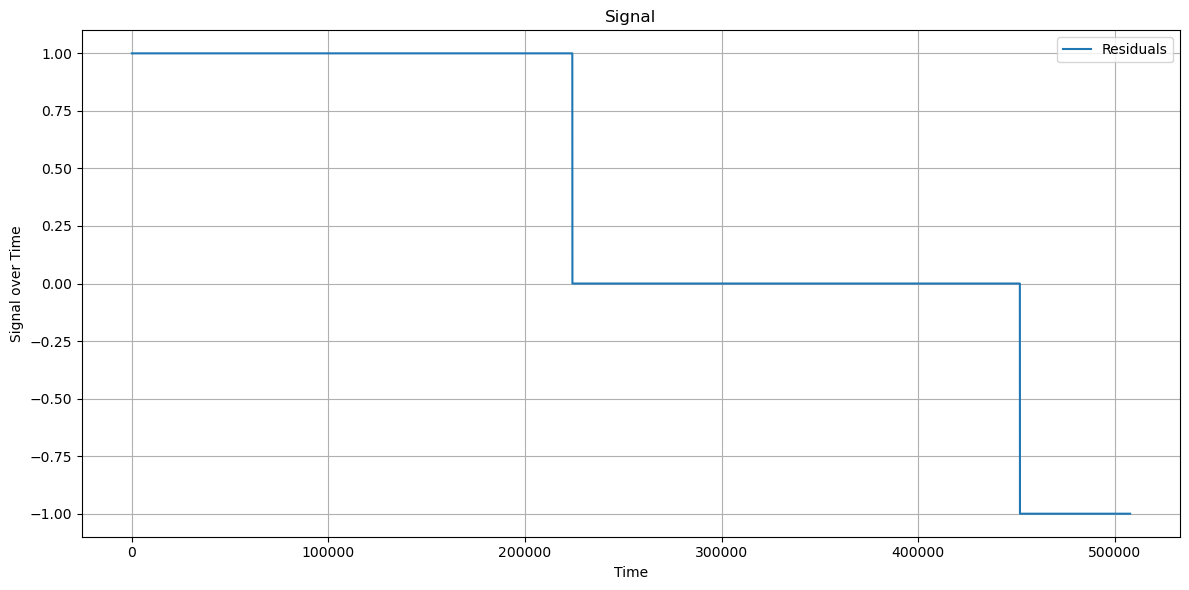

In [318]:
plt.figure(figsize=(12, 6))
plt.plot(positions[4], label='Residuals')
plt.title("Signal")
plt.xlabel("Time")
plt.ylabel("Signal over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Running the backtesting simulator (using rolling windows to avoid look-ahead bias)

In [231]:
from simulator import Simulator

In [269]:
start = 0
end = 2000
a = 12

In [314]:
sim = Simulator(
    data_dict=data_dict,
    ret_window=2440,
    pca_window=2440,
    ou_window=2440,
    k=6,
    s_entry=2.5,
    s_exit=0.175,
    pca_update_interval=20,
    start_index= start + a*1000,
    end_index= end + a*1000    
)


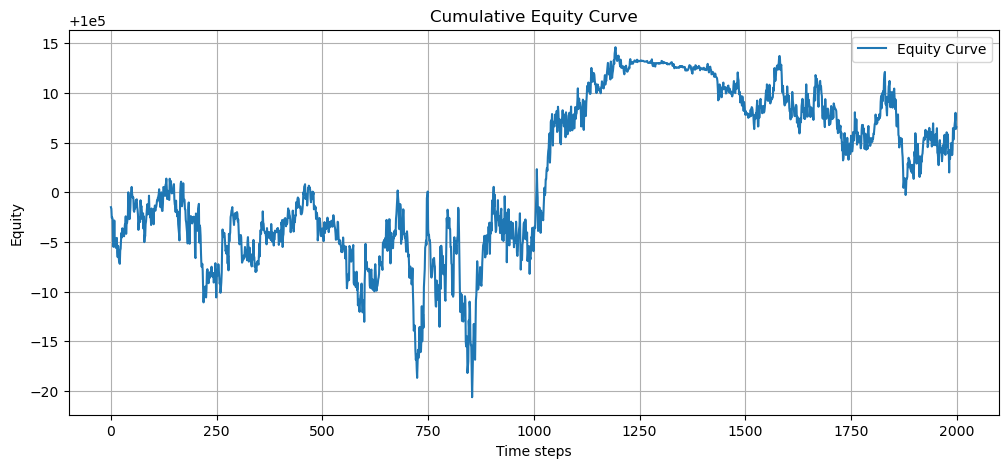

In [315]:
sim.run_simulation()
sim.plot_equity_curve()